In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.forecasting.model_selection import temporal_train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.forecasting.base import ForecastingHorizon
warnings.filterwarnings('ignore')
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [9]:
train = pd.read_csv('divvy_station_train.csv')
test = pd.read_csv('divvy_station_test.csv')
train.head()

date                    start_station_name start_station_id  \
0  2020-01-01                         63rd St Beach              101   
1  2020-01-01               Orleans St & Hubbard St              636   
2  2020-01-01                   Orleans St & Elm St               23   
3  2020-01-01  Orleans St & Chestnut St (NEXT Apts)              620   
4  2020-01-01              Ogden Ave & Roosevelt Rd              434   

   total_rides  ebike_rides  ebike_proportion  ebike_proportion_ma365  \
0            2            0               0.0                     0.0   
1            5            0               0.0                     0.0   
2            3            0               0.0                     0.0   
3            5            0               0.0                     0.0   
4            2            0               0.0                     0.0   

   ebike_proportion_ma30  ebike_proportion_diff  ebike_shift  temp_min_c  \
0                    0.0                    NaN          NaN        -5.5   
1                    0.0                    0.0          0.0        -5.5   
2                    0.0                    0.0          0.0        -5.5   
3                    0.0                    0.0          0.0        -5.5   
4                    0.0                    0.0          0.0        -5.5   

   rain_sum_mm  snowfall_sum_cm  month  dayofweek  year  
0          0.0              0.0      1          2  2020  
1          0.0              0.0      1          2  2020  
2          0.0              0.0      1          2  2020  
3          0.0              0.0      1          2  2020  
4          0.0              0.0      1          2  2020

In [21]:
train.describe()

date    total_rides    ebike_rides  \
count                         423834  423834.000000  423834.000000   
mean   2022-01-03 20:25:02.195670528      33.498476      10.604305   
min              2020-01-01 00:00:00       1.000000       0.000000   
25%              2021-01-03 00:00:00      10.000000       2.000000   
50%              2022-01-05 00:00:00      23.000000       7.000000   
75%              2023-01-04 00:00:00      44.000000      15.000000   
max              2023-12-31 00:00:00    1168.000000     317.000000   
std                              NaN      36.548552      12.413809   

       ebike_proportion  ebike_proportion_ma365  ebike_proportion_ma30  \
count     423834.000000           423834.000000          423834.000000   
mean           0.319170                0.391809               0.379823   
min            0.000000                0.000000               0.000000   
25%            0.153846                0.297109               0.275697   
50%            0.333333                0.455546               0.425629   
75%            0.470588                0.544911               0.524310   
max            1.000000                0.718429               0.992308   
std            0.222881                0.199497               0.201431   

       ebike_proportion_diff    ebike_shift     temp_min_c    rain_sum_mm  \
count          423834.000000  423834.000000  423834.000000  423834.000000   
mean               -0.033330       0.352501       6.988836       2.088266   
min                -1.000000       0.000000     -23.000000       0.000000   
25%                -0.140000       0.100000      -0.100000       0.000000   
50%                 0.000000       0.333333       6.100000       0.000000   
75%                 0.100000       0.500000      16.000000       0.400000   
max                 1.000000       1.000000      26.400000      79.100000   
std                 0.274862       0.292775       9.646748       6.892309   

       snowfall_sum_cm          month     dayofweek           year  
count    423834.000000  423834.000000  423834.00000  423834.000000  
mean          0.122334       6.552195       2.99891    2021.507114  
min           0.000000       1.000000       0.00000    2020.000000  
25%           0.000000       4.000000       1.00000    2021.000000  
50%           0.000000       7.000000       3.00000    2022.000000  
75%           0.000000      10.000000       5.00000    2023.000000  
max          11.480000      12.000000       6.00000    2023.000000  
std           0.664187       3.434800       1.99578       1.119048

In [22]:
test.describe()

date    total_rides    ebike_rides  \
count                         248477  248477.000000  248477.000000   
mean   2024-07-05 19:48:16.855644672      19.263067       7.945327   
min              2024-01-01 00:00:00       1.000000       0.000000   
25%              2024-04-15 00:00:00       2.000000       1.000000   
50%              2024-07-08 00:00:00       8.000000       4.000000   
75%              2024-09-27 00:00:00      25.000000      10.000000   
max              2024-12-31 00:00:00     796.000000     201.000000   
std                              NaN      29.217215      11.056512   

       ebike_proportion  ebike_proportion_ma365  ebike_proportion_ma30  \
count     248477.000000           248477.000000          248477.000000   
mean           0.509644                0.509590               0.509653   
min            0.000000                0.012648               0.000000   
25%            0.294118                0.471149               0.434838   
50%            0.469697                0.516214               0.492180   
75%            0.750000                0.559098               0.556405   
max            1.000000                0.743177               1.000000   
std            0.324031                0.069493               0.133983   

       ebike_proportion_diff    ebike_shift     temp_min_c    rain_sum_mm  \
count          248477.000000  248477.000000  248477.000000  248477.000000   
mean               -0.000001       0.509645       8.908615       1.465855   
min                -1.000000       0.000000     -24.000000       0.000000   
25%                -0.200000       0.294118       1.700000       0.000000   
50%                 0.000000       0.469697       9.400000       0.000000   
75%                 0.200000       0.750000      16.300000       0.400000   
max                 1.000000       1.000000      24.700000      45.200000   
std                 0.396999       0.324029       8.924886       4.281100   

       snowfall_sum_cm          month      dayofweek      year  
count    248477.000000  248477.000000  248477.000000  248477.0  
mean          0.076877       6.658097       2.966657    2024.0  
min           0.000000       1.000000       0.000000    2024.0  
25%           0.000000       4.000000       1.000000    2024.0  
50%           0.000000       7.000000       3.000000    2024.0  
75%           0.000000       9.000000       5.000000    2024.0  
max           9.380000      12.000000       6.000000    2024.0  
std           0.624504       3.269554       1.991792       0.0

In [10]:
train.isna().sum()

date                      0
start_station_name        0
start_station_id          0
total_rides               0
ebike_rides               0
ebike_proportion          0
ebike_proportion_ma365    0
ebike_proportion_ma30     0
ebike_proportion_diff     1
ebike_shift               1
temp_min_c                0
rain_sum_mm               0
snowfall_sum_cm           0
month                     0
dayofweek                 0
year                      0
dtype: int64

In [11]:
test.dtypes

date                       object
start_station_name         object
start_station_id           object
total_rides                 int64
ebike_rides                 int64
ebike_proportion          float64
ebike_proportion_ma365    float64
ebike_proportion_ma30     float64
ebike_proportion_diff     float64
ebike_shift               float64
temp_min_c                float64
rain_sum_mm               float64
snowfall_sum_cm           float64
month                       int64
dayofweek                   int64
year                        int64
dtype: object

In [12]:
# Make date column datetime for both train and test
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [13]:
# Get the counts of each station name
station_counts = train['start_station_name'].value_counts()

# Filter out station names that have counts under 1400
stations_to_keep = station_counts[station_counts >= 1400].index

# Filter the train DataFrame to include only these stations
train = train[train['start_station_name'].isin(stations_to_keep)]

### Prophet stationwide
- Comparing each stations 'mean' rides per day in the training data to the forecasted mean ride per day.
- Ranking them based on which statio have the highest forecasted improvement.

Station: Calumet Ave & 33rd St, Percentage Growth: 149.85%
Station: MLK Jr Dr & 29th St, Percentage Growth: 130.97%
Station: State St & 35th St, Percentage Growth: 84.12%
Station: State St & 33rd St, Percentage Growth: 80.78%
Station: Morgan St & Polk St, Percentage Growth: 68.49%
Station: Clinton St & Jackson Blvd, Percentage Growth: 68.42%
Station: Canal St & Jackson Blvd, Percentage Growth: 64.30%
Station: Paulina St & Montrose Ave, Percentage Growth: 64.03%
Station: Clinton St & Washington Blvd, Percentage Growth: 63.59%
Station: Canal St & Madison St, Percentage Growth: 63.32%
Station: Calumet Ave & 33rd St, R²: -0.26558776096146874


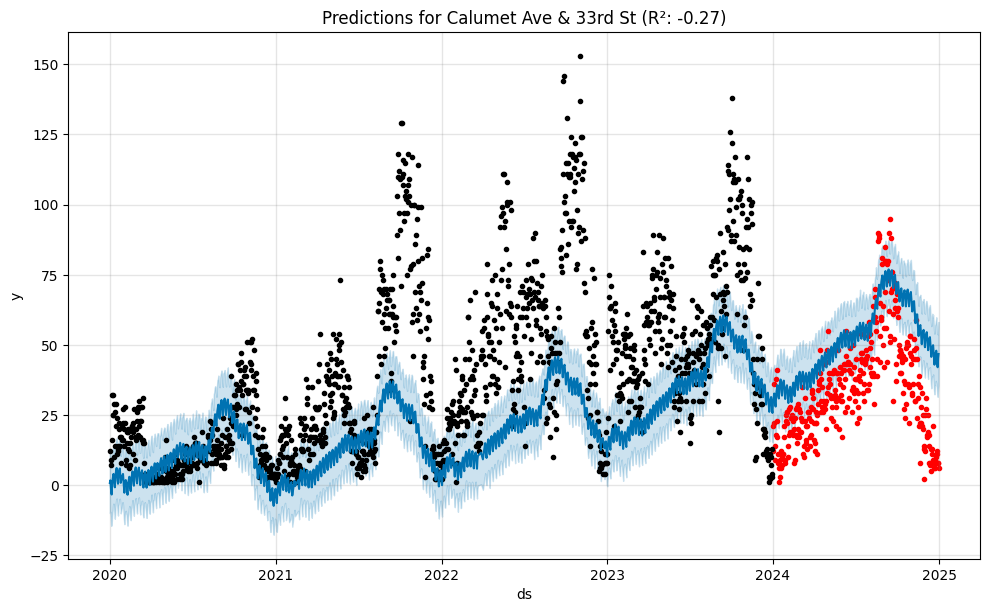

Station: MLK Jr Dr & 29th St, R²: -0.4966147830016867


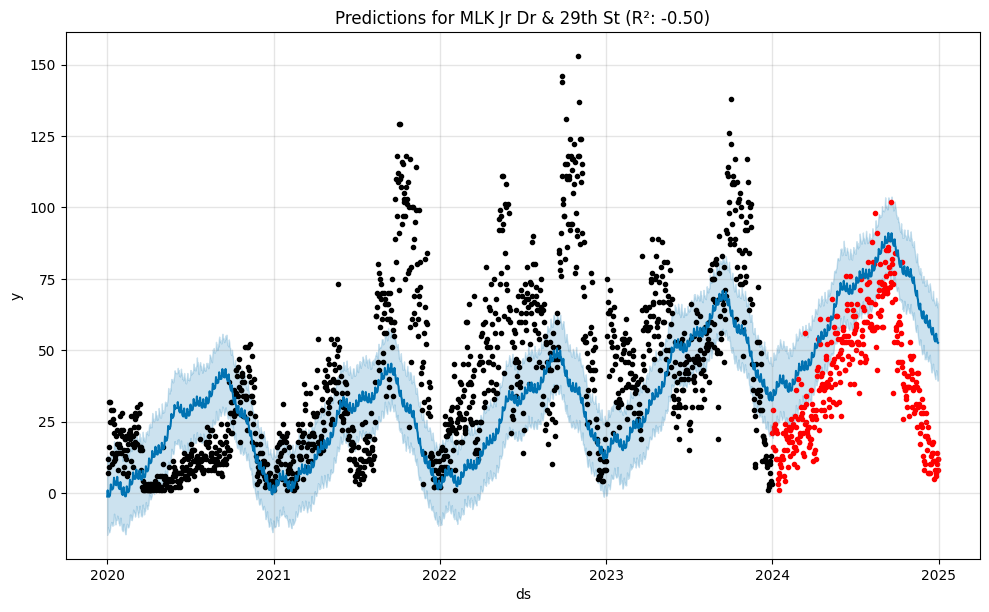

Station: State St & 35th St, R²: -0.4941602417311004


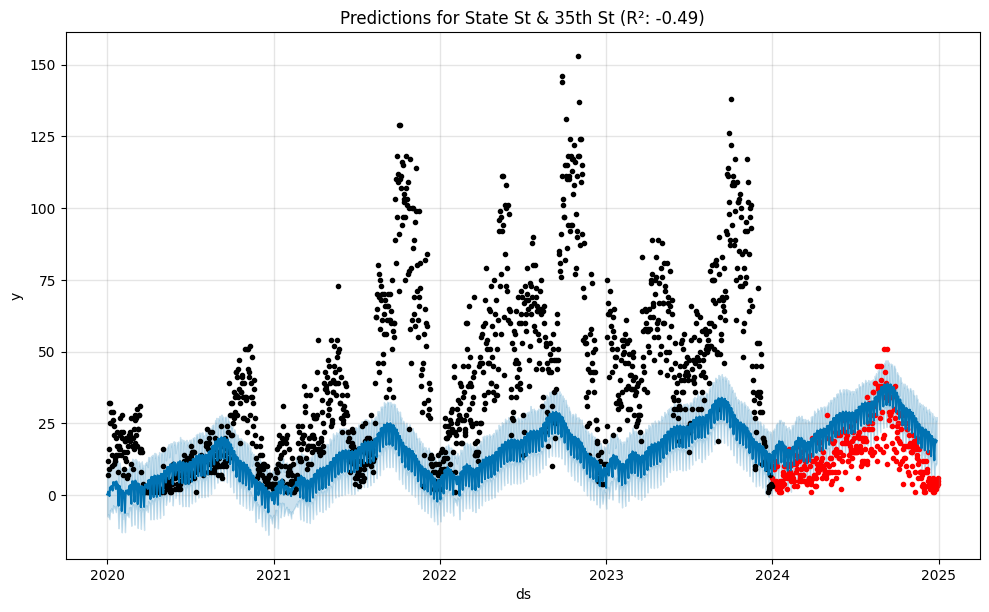

Station: State St & 33rd St, R²: 0.21779017780137955


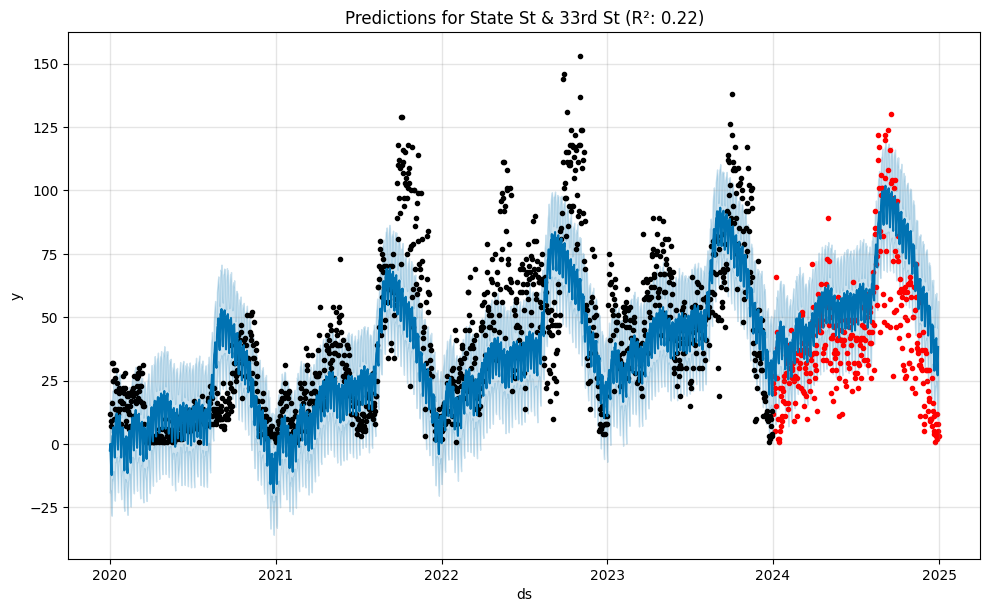

Station: Morgan St & Polk St, R²: 0.566211430140988


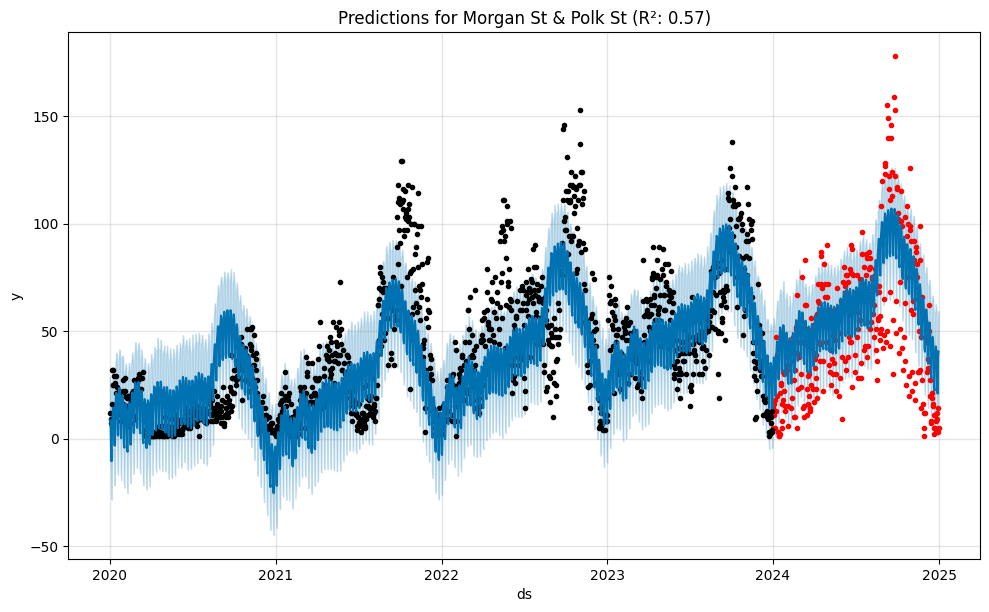

Station: Clinton St & Jackson Blvd, R²: 0.6086204936375248


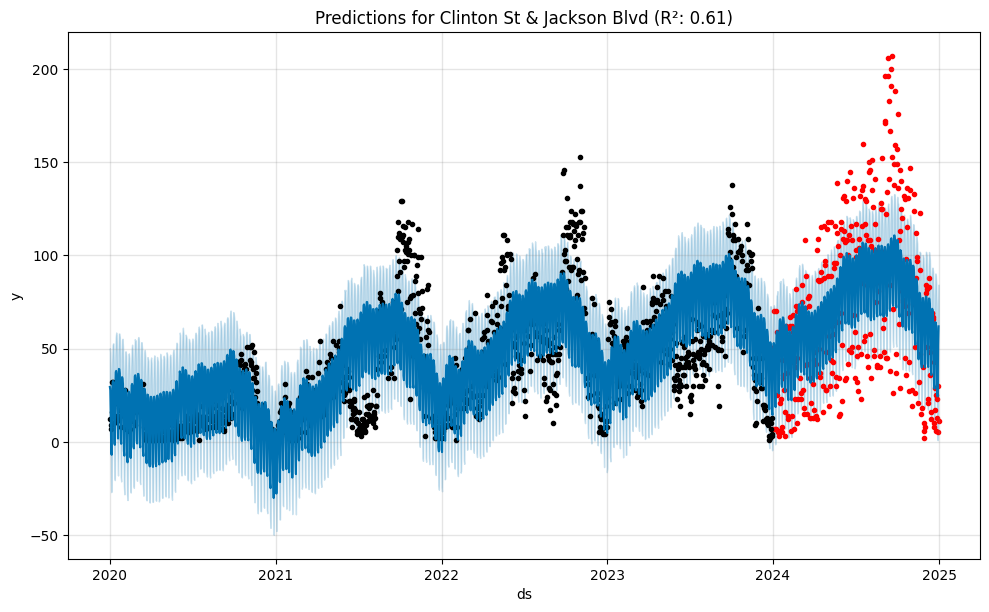

Station: Canal St & Jackson Blvd, R²: -0.7693855610511202


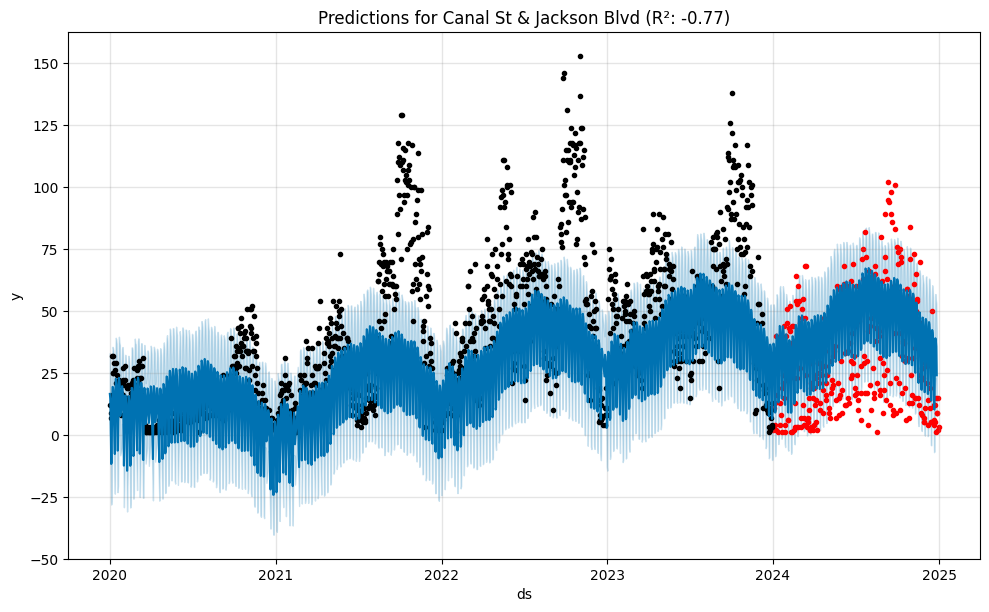

Station: Paulina St & Montrose Ave, R²: 0.193447385738159


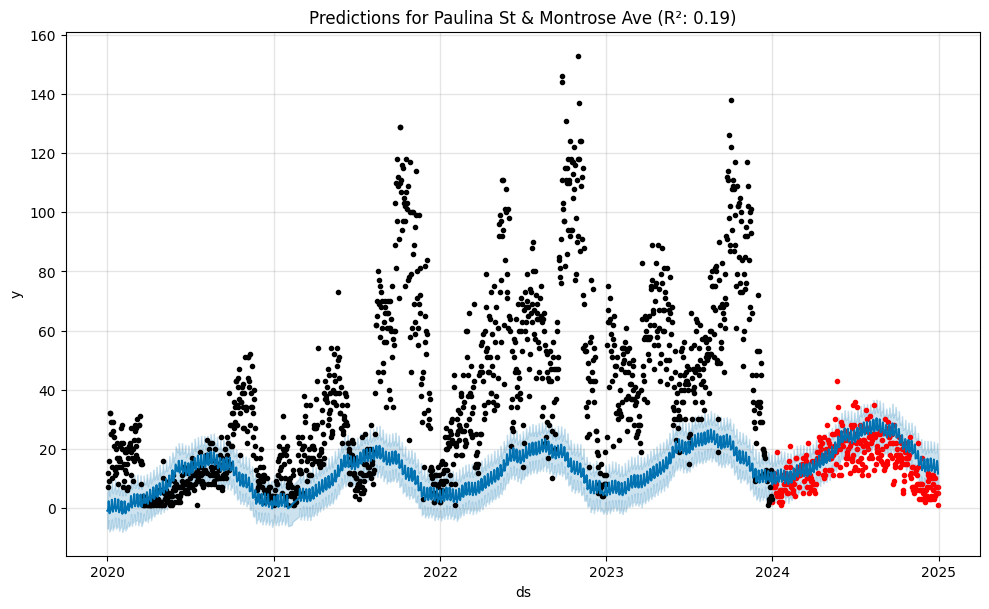

Station: Clinton St & Washington Blvd, R²: 0.6226385967338111


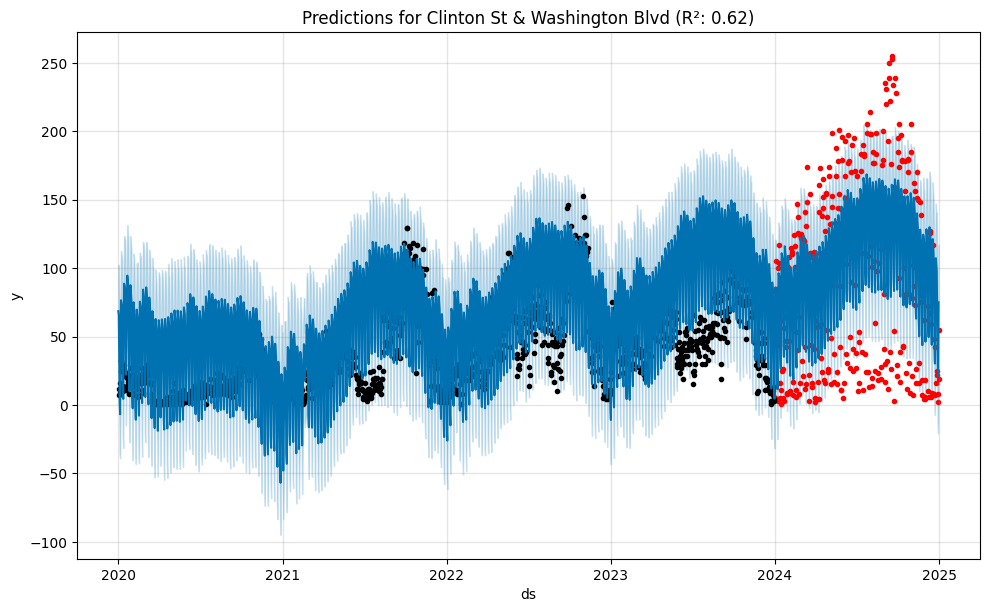

Station: Canal St & Madison St, R²: 0.49556580392775873


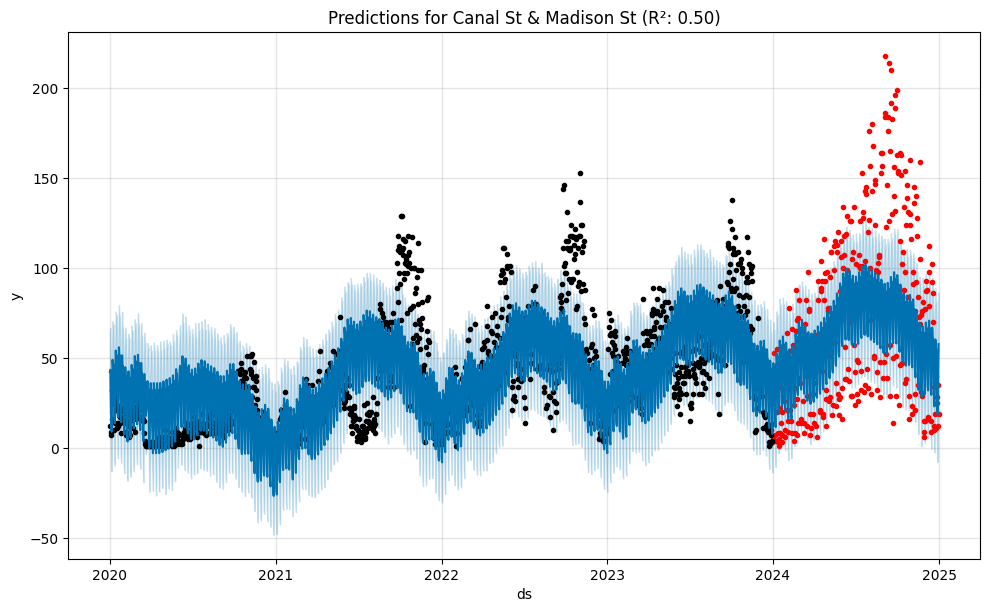

In [14]:
from prophet import Prophet
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Suppress cmdstanpy informational messages
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

# Prepare a dictionary to store the results
results = {}
growth = []

# Group by station
stations = train['start_station_name'].unique()

for station in stations:
    # Filter data for the current station
    df_train_station = train[train['start_station_name'] == station]
    df_test_station = test[test['start_station_name'] == station]

    # Prepare the data for Prophet
    df_prophet_train = df_train_station[['date', 'total_rides']].rename(columns={'date': 'ds', 'total_rides': 'y'})
    df_prophet_test = df_test_station[['date', 'total_rides']].rename(columns={'date': 'ds', 'total_rides': 'y'})

    # Check if the training data has at least 2 non-NaN rows
    if df_prophet_train['y'].notnull().sum() < 2:
        print(f"Skipping station {station} due to insufficient data")
        continue

    # Calculate the mean rides in the training data
    mean_train_rides = df_prophet_train['y'].mean()

    # Create and fit the Prophet model
    model = Prophet()
    model.fit(df_prophet_train)

    # Create future dates for prediction
    future = model.make_future_dataframe(periods=len(df_prophet_test), freq='D')

    # Make predictions
    forecast_data = model.predict(future)

    # Calculate the mean predicted rides for the test period
    mean_test_rides = forecast_data['yhat'][-len(df_prophet_test):].mean()

    # Calculate the percentage growth
    if mean_train_rides != 0:
        growth_value = ((mean_test_rides - mean_train_rides) / mean_train_rides) * 100
    else:
        growth_value = 0
    growth.append((station, growth_value))

    # Store the results
    results[station] = forecast_data

# Sort the stations by percentage growth and select the top 10
top_10_stations = sorted(growth, key=lambda x: x[1], reverse=True)[:10]

# Print the top 10 stations with the most improved percentage growth
for station, growth_value in top_10_stations:
    print(f"Station: {station}, Percentage Growth: {growth_value:.2f}%")

# Optionally, plot the results for the top 10 stations and print R² score
for station, _ in top_10_stations:
    forecast_data = results[station]
    df_prophet_test = test[test['start_station_name'] == station][['date', 'total_rides']].rename(columns={'date': 'ds', 'total_rides': 'y'})

    # Calculate R² score
    y_true = df_prophet_test['y']
    y_pred = forecast_data['yhat'][-len(df_prophet_test):]
    r2 = r2_score(y_true, y_pred)
    print(f"Station: {station}, R²: {r2}")

    # Plot the results
    fig = model.plot(forecast_data)
    plt.scatter(pd.to_datetime(df_prophet_test['ds']), pd.to_numeric(df_prophet_test['y']), color='r', marker='.')
    plt.title(f'Predictions for {station} (R²: {r2:.2f})')
    plt.show()

### Prophet Stationwide using temp as external regessor

Station: Calumet Ave & 33rd St, Percentage Growth: 149.33%
Station: MLK Jr Dr & 29th St, Percentage Growth: 131.45%
Station: State St & 35th St, Percentage Growth: 85.15%
Station: State St & 33rd St, Percentage Growth: 82.18%
Station: Morgan St & Polk St, Percentage Growth: 68.47%
Station: Clinton St & Jackson Blvd, Percentage Growth: 68.20%
Station: Paulina St & Montrose Ave, Percentage Growth: 65.05%
Station: Canal St & Jackson Blvd, Percentage Growth: 64.99%
Station: Clinton St & Washington Blvd, Percentage Growth: 63.39%
Station: Canal St & Madison St, Percentage Growth: 62.07%
Station: Calumet Ave & 33rd St, R²: -0.2446354459892084


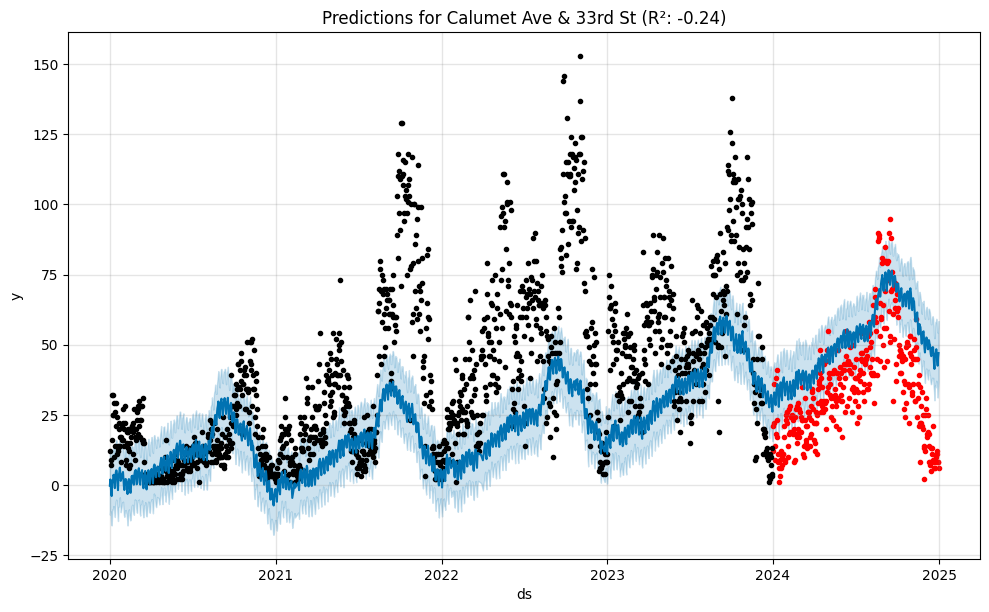

Station: MLK Jr Dr & 29th St, R²: -0.4934366353891211


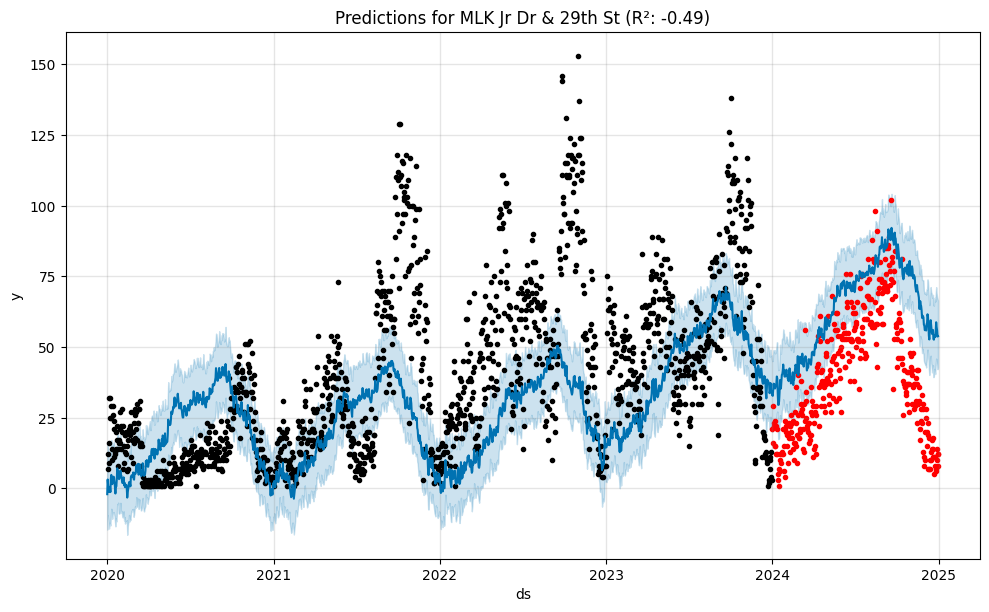

Station: State St & 35th St, R²: -0.5155310648020808


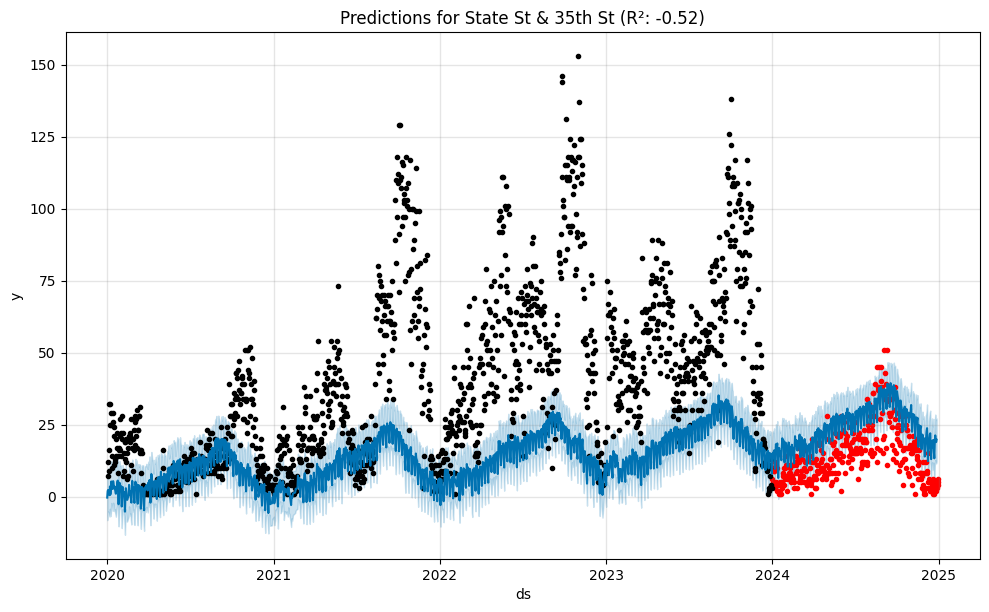

Station: State St & 33rd St, R²: 0.20709360101011964


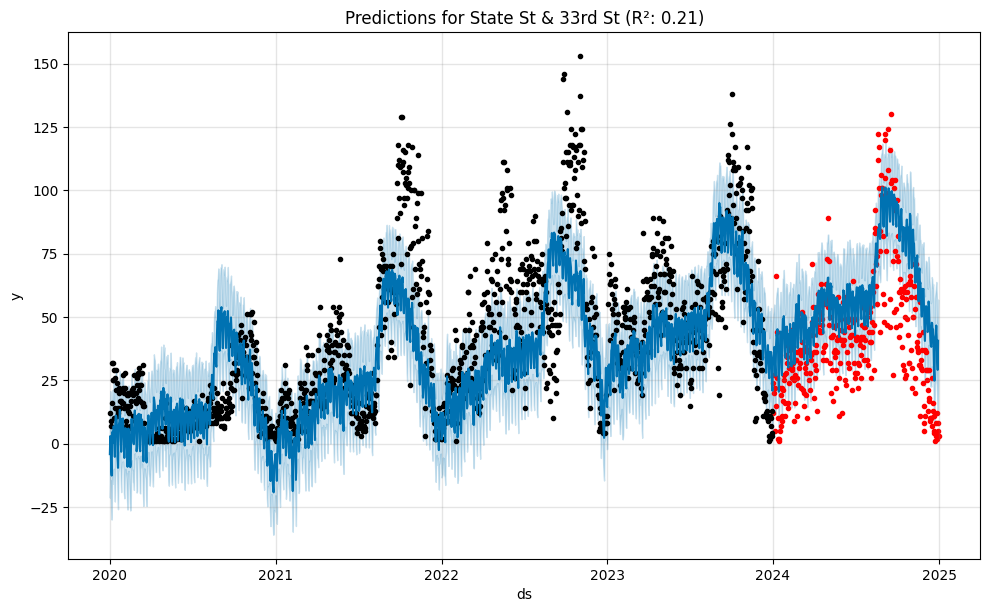

Station: Morgan St & Polk St, R²: 0.5797204352327443


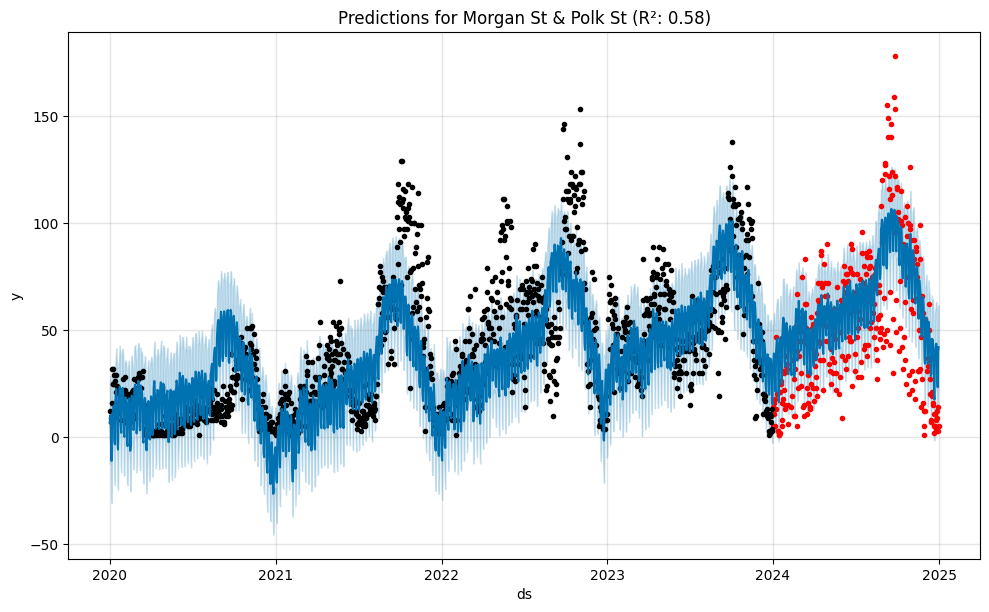

Station: Clinton St & Jackson Blvd, R²: 0.6102711865554071


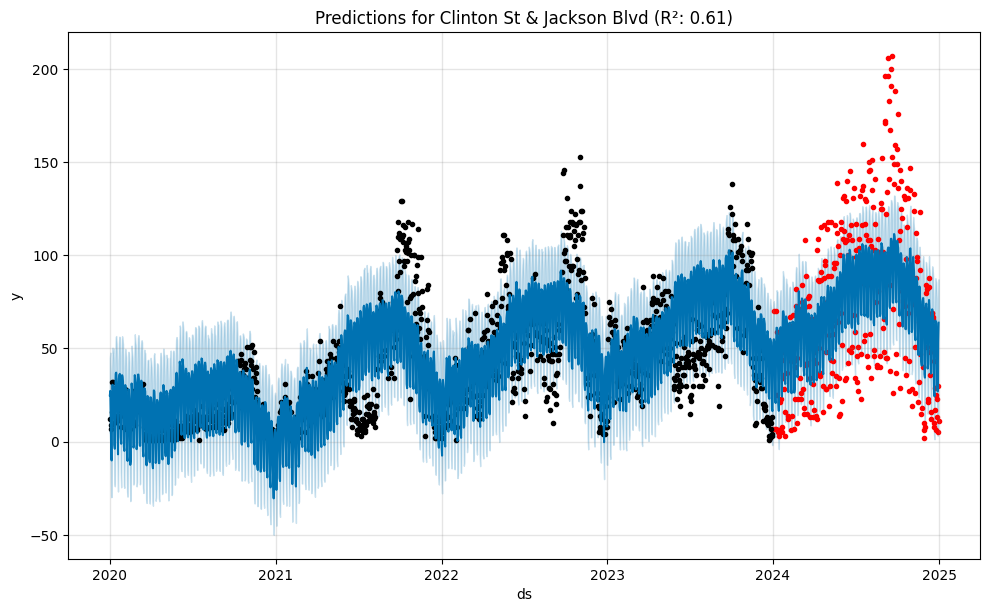

Station: Paulina St & Montrose Ave, R²: 0.21685554099334836


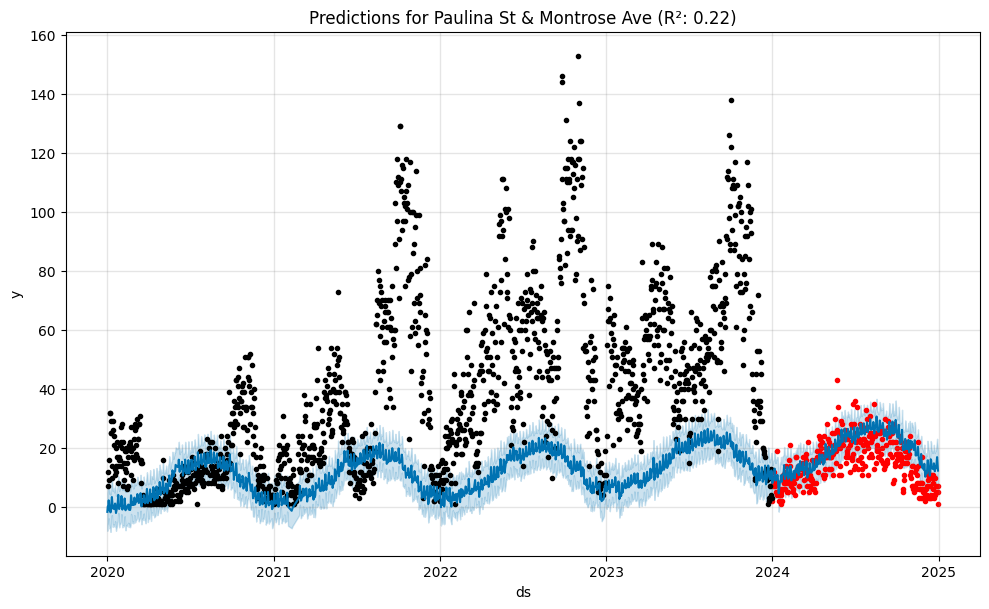

Station: Canal St & Jackson Blvd, R²: -0.762323100507448


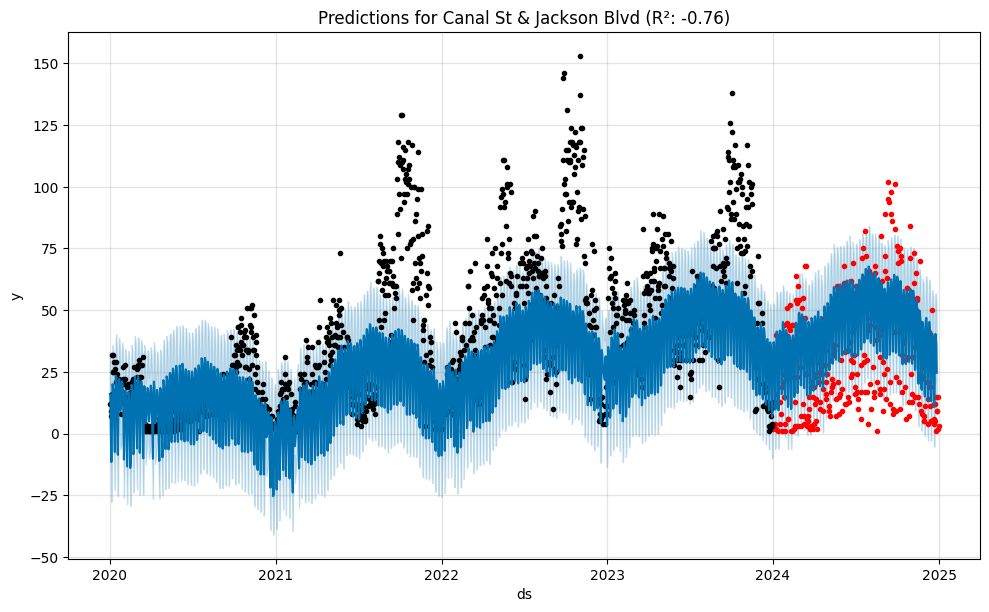

Station: Clinton St & Washington Blvd, R²: 0.6290356303937543


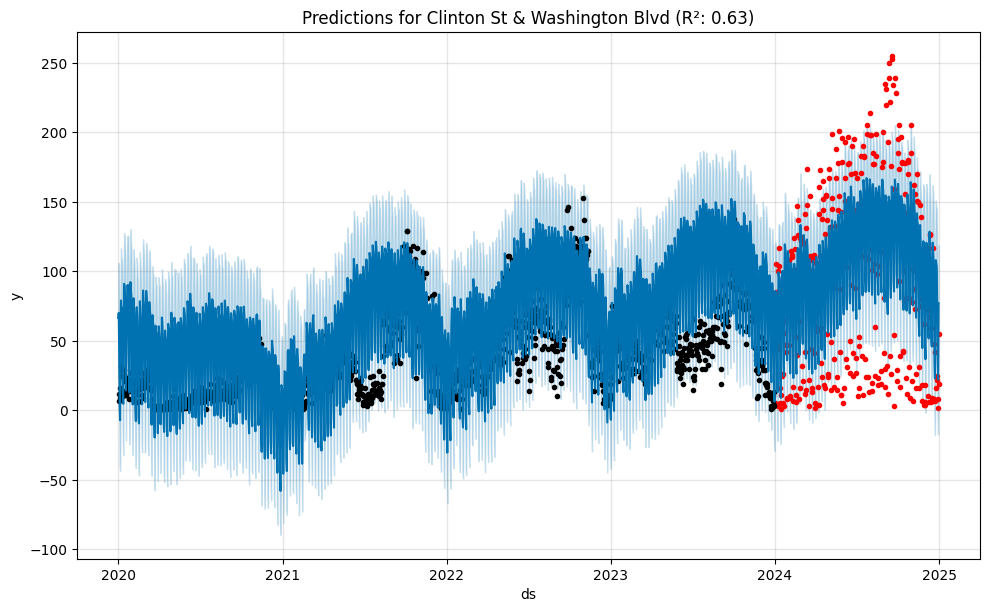

Station: Canal St & Madison St, R²: 0.4947458280470276


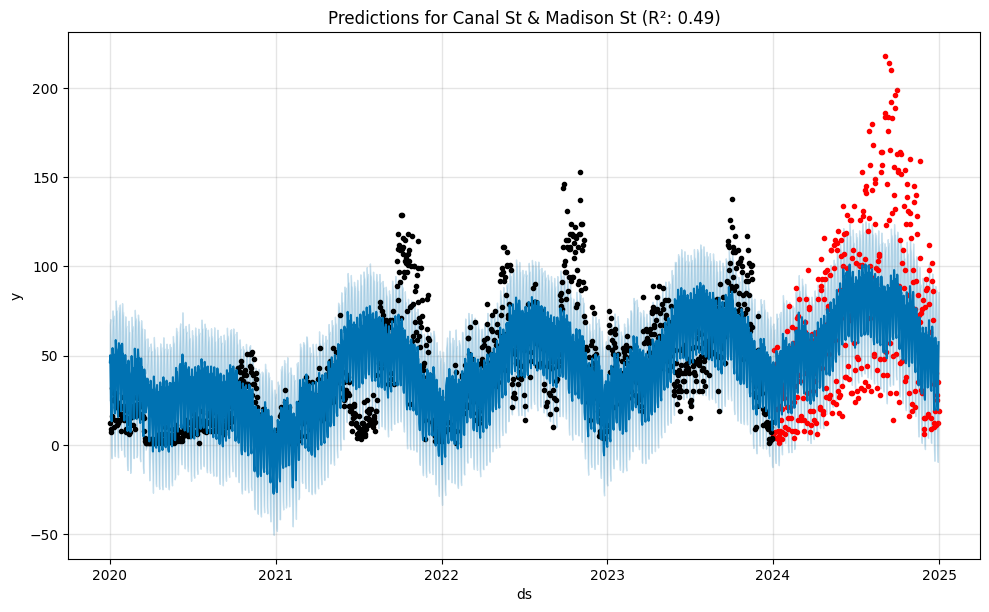

In [15]:
from prophet import Prophet
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Prepare a dictionary to store the results
results = {}
growth = []

# Group by station
stations = train['start_station_name'].unique()

for station in stations:
    # Filter data for the current station
    df_train_station = train[train['start_station_name'] == station]
    df_test_station = test[test['start_station_name'] == station]

    # Prepare the data for Prophet
    df_prophet_train = df_train_station[['date', 'total_rides', 'temp_min_c']].rename(columns={'date': 'ds', 'total_rides': 'y'})
    df_prophet_test = df_test_station[['date', 'total_rides', 'temp_min_c']].rename(columns={'date': 'ds', 'total_rides': 'y'})

    # Check if the training data has at least 2 non-NaN rows
    if df_prophet_train['y'].notnull().sum() < 2:
        continue

    # Calculate the mean rides in the training data
    mean_train_rides = df_prophet_train['y'].mean()

    # Create and fit the Prophet model with external regressor
    model = Prophet()
    model.add_regressor('temp_min_c')
    model.fit(df_prophet_train)

    # Create future dates for prediction
    future = model.make_future_dataframe(periods=len(df_prophet_test), freq='D')
    future['temp_min_c'] = pd.concat([df_prophet_train['temp_min_c'], df_prophet_test['temp_min_c']], ignore_index=True)

    # Make predictions
    forecast_data = model.predict(future)

    # Calculate the mean predicted rides for the test period
    mean_test_rides = forecast_data['yhat'][-len(df_prophet_test):].mean()

    # Calculate the percentage growth
    if mean_train_rides != 0:
        growth_value = ((mean_test_rides - mean_train_rides) / mean_train_rides) * 100
    else:
        growth_value = 0
    growth.append((station, growth_value))

    # Store the results
    results[station] = forecast_data

# Sort the stations by percentage growth and select the top 10
top_10_stations = sorted(growth, key=lambda x: x[1], reverse=True)[:10]

# Print the top 10 stations with the most improved percentage growth
for station, growth_value in top_10_stations:
    print(f"Station: {station}, Percentage Growth: {growth_value:.2f}%")

# Optionally, plot the results for the top 10 stations and print R² score
for station, _ in top_10_stations:
    forecast_data = results[station]
    df_prophet_test = test[test['start_station_name'] == station][['date', 'total_rides']].rename(columns={'date': 'ds', 'total_rides': 'y'})

    # Calculate R² score
    y_true = df_prophet_test['y']
    y_pred = forecast_data['yhat'][-len(df_prophet_test):]
    r2 = r2_score(y_true, y_pred)
    print(f"Station: {station}, R²: {r2}")

    # Plot the results
    fig = model.plot(forecast_data)
    plt.scatter(pd.to_datetime(df_prophet_test['ds']), pd.to_numeric(df_prophet_test['y']), color='r', marker='.')
    plt.title(f'Predictions for {station} (R²: {r2:.2f})')
    plt.show()

### XGBoost

Station: Chicago Ave & Washington St, Growth: 27.16%
Station: Marine Dr & Ainslie St, Growth: 23.77%
Station: Fairbanks Ct & Grand Ave, Growth: 23.16%
Station: Paulina Ave & North Ave, Growth: 22.09%
Station: Sheffield Ave & Willow St, Growth: 21.62%
Station: Mies van der Rohe Way & Chestnut St, Growth: 20.93%
Station: St. Clair St & Erie St, Growth: 20.42%
Station: Ada St & Washington Blvd, Growth: 19.79%
Station: Ashland Ave & Blackhawk St, Growth: 19.36%
Station: Clark St & Chicago Ave, Growth: 19.24%


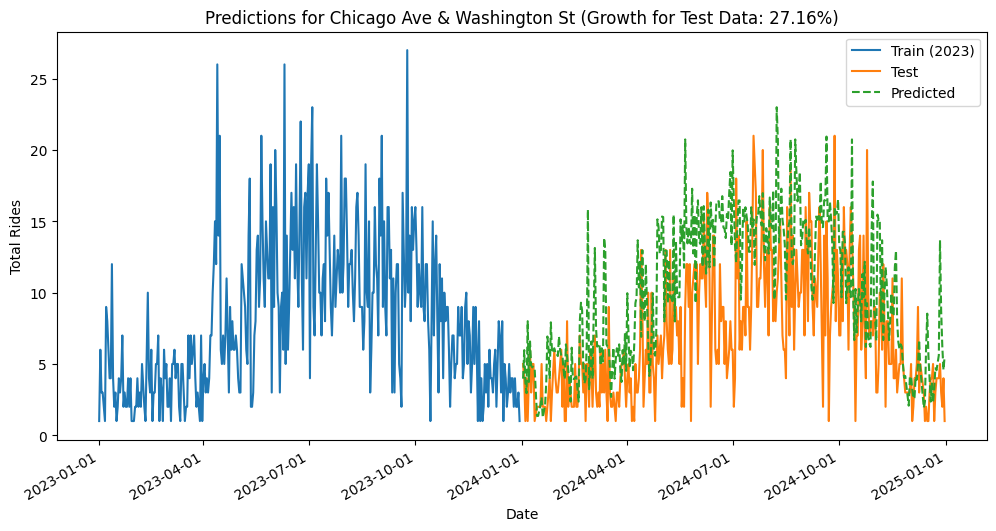

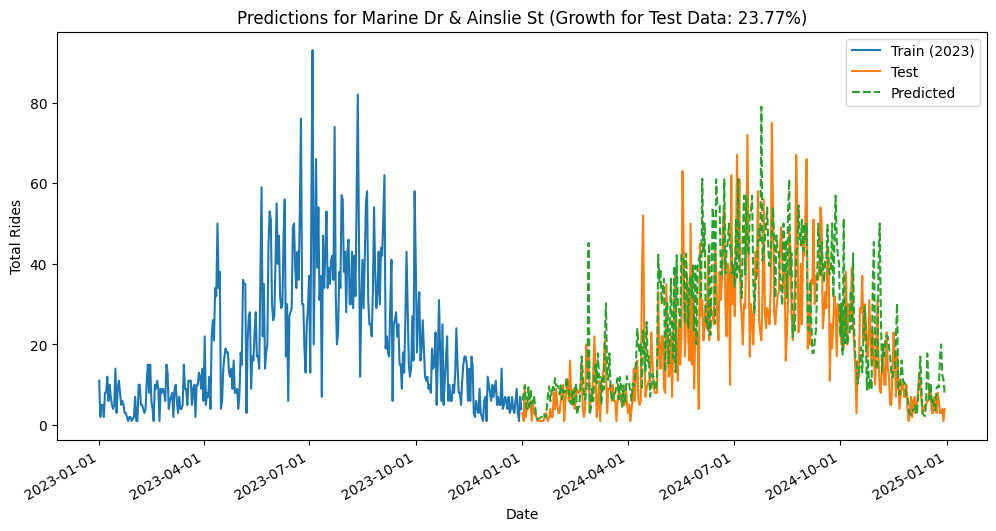

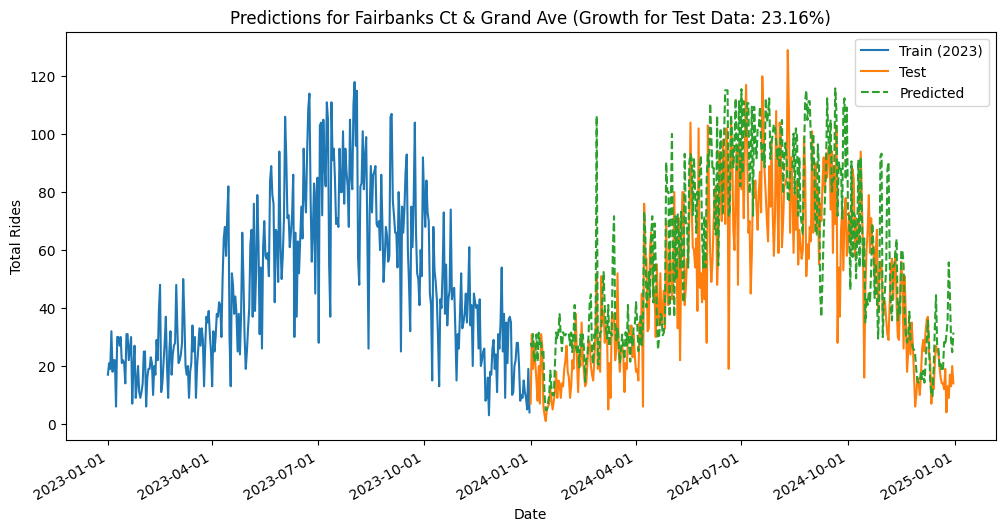

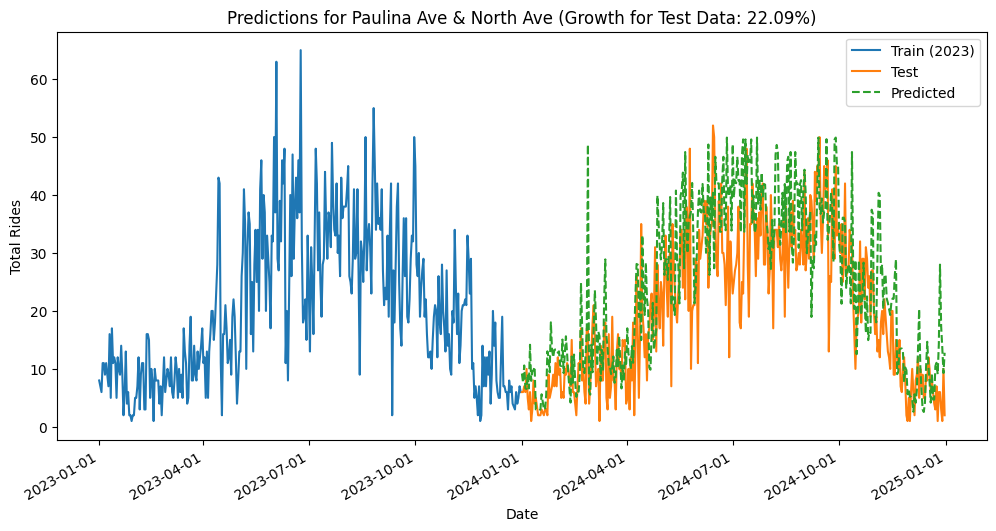

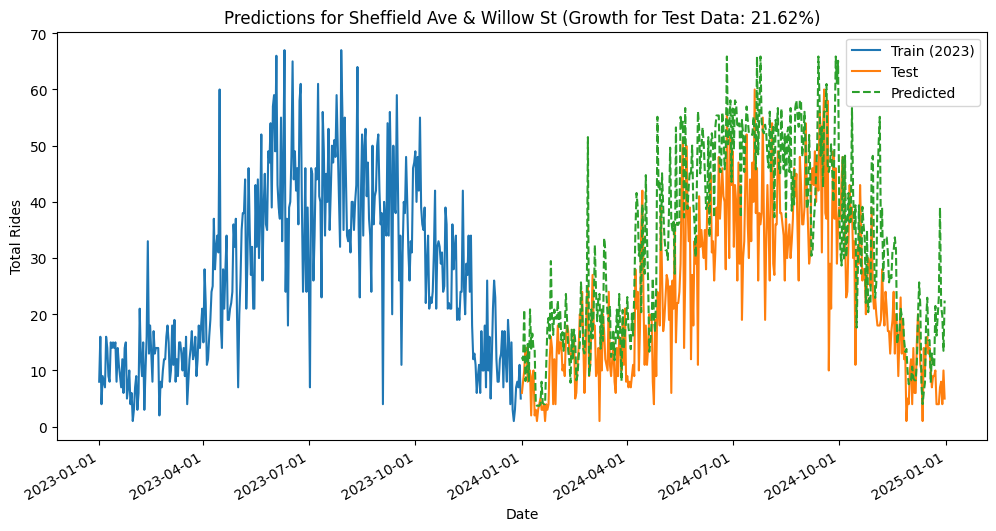

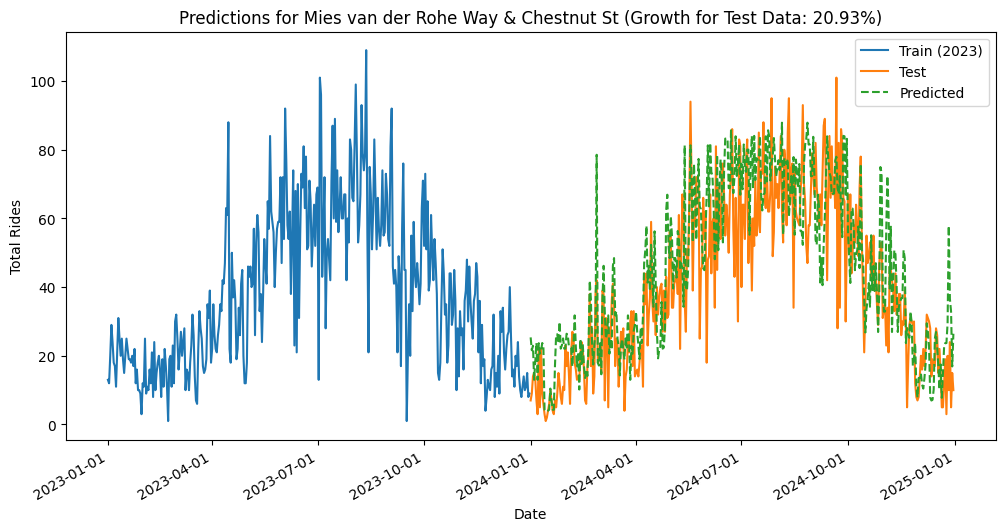

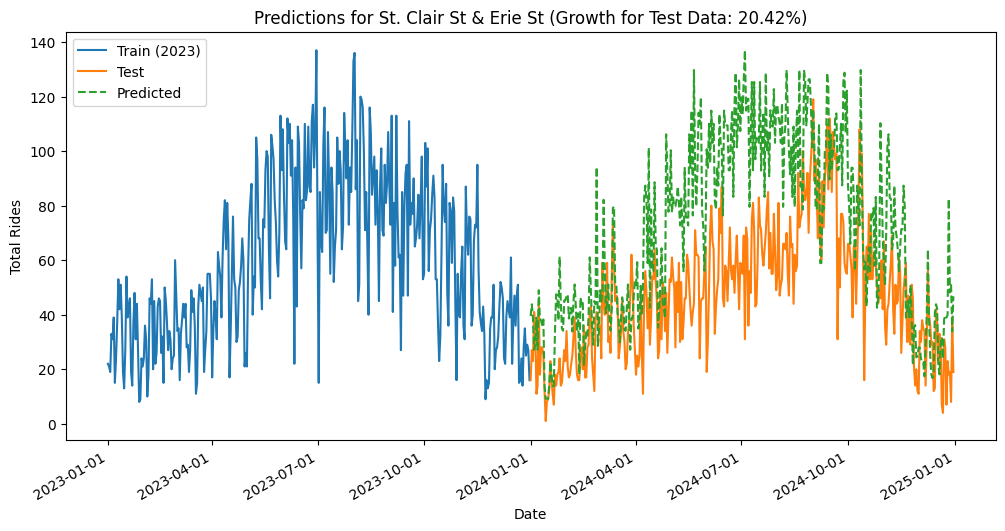

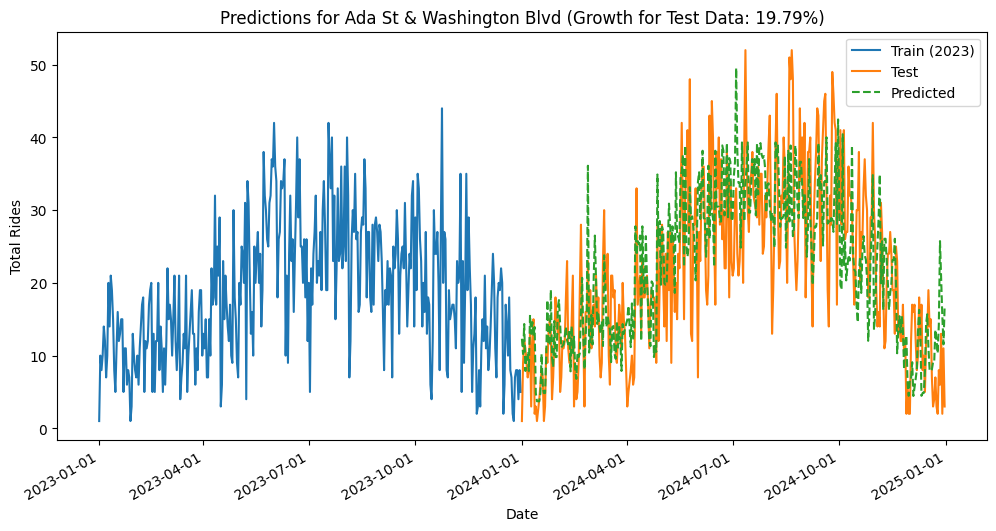

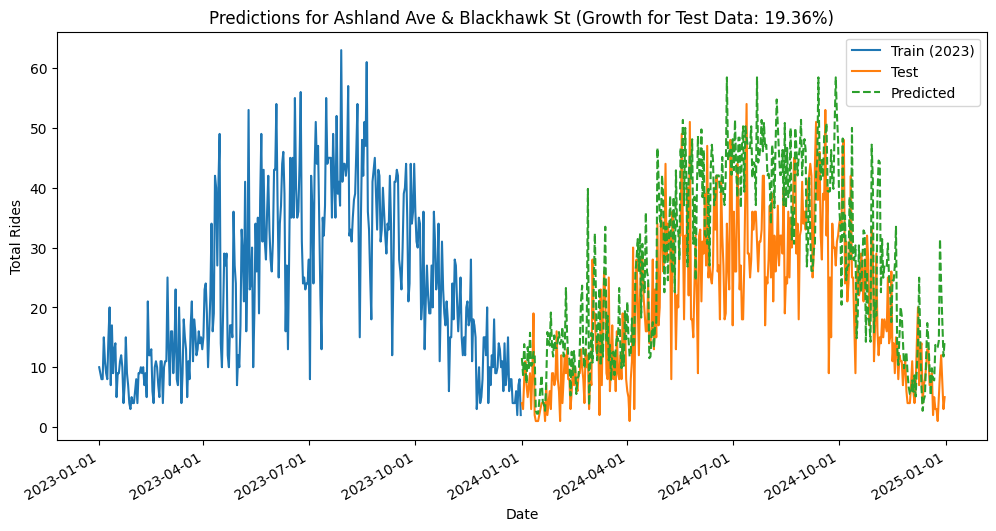

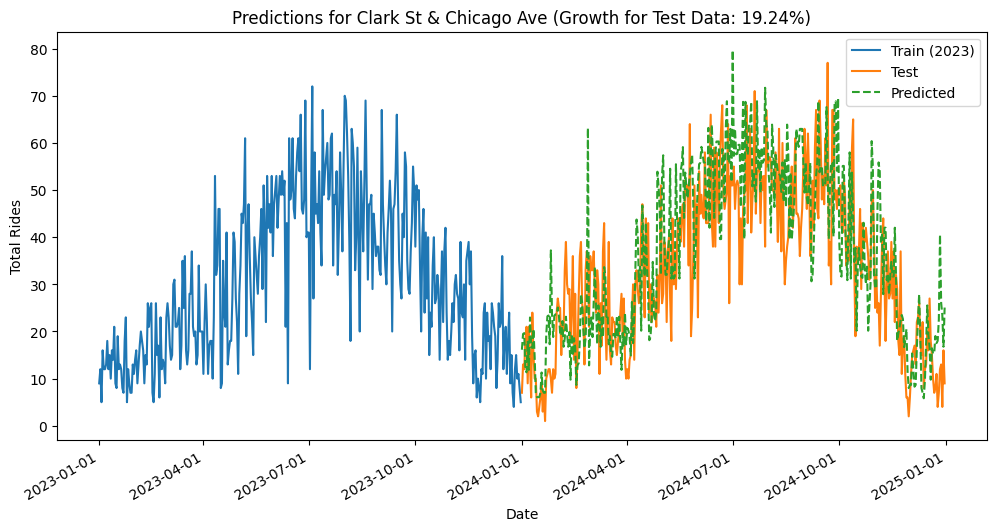

In [25]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Prepare a dictionary to store the results
results = {}
growth = []

# Group by station
stations = train['start_station_name'].unique()

for station in stations:
    # Filter data for the current station
    df_train_station = train[train['start_station_name'] == station]
    df_test_station = test[test['start_station_name'] == station]

    # Prepare the data for XGBoost
    df_train_station = df_train_station[['date', 'total_rides', 'temp_min_c']]
    df_test_station = df_test_station[['date', 'total_rides', 'temp_min_c']]

    # Check if the training data has at least 2 non-NaN rows
    if df_train_station['total_rides'].notnull().sum() < 2:
        continue

    # Filter the training data to only include the year 2023
    df_train_station['date'] = pd.to_datetime(df_train_station['date'])
    df_train_2023 = df_train_station[df_train_station['date'].dt.year == 2023]

    # Calculate the average rides per day for the year 2023
    avg_rides_per_day_2023 = df_train_2023['total_rides'].mean()

    # Prepare the data for XGBoost
    X_train = df_train_station[['temp_min_c']]
    y_train = df_train_station['total_rides']
    X_test = df_test_station[['temp_min_c']]
    y_test = df_test_station['total_rides']

    # Create and fit the XGBoost model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the mean predicted rides for the test period
    mean_test_rides = y_pred.mean()

    # Calculate the percentage growth
    if avg_rides_per_day_2023 != 0:
        growth_value = ((mean_test_rides - avg_rides_per_day_2023) / avg_rides_per_day_2023) * 100
    else:
        growth_value = 0
    growth.append((station, growth_value))

    # Store the results
    results[station] = (df_train_2023, df_test_station, y_pred, y_test, growth_value)

# Sort the stations by growth and select the top 10
top_10_stations = sorted(growth, key=lambda x: x[1], reverse=True)[:10]

# Print the top 10 stations with the most improved growth
for station, growth_value in top_10_stations:
    print(f"Station: {station}, Growth: {growth_value:.2f}%")

# Optionally, plot the results for the top 10 stations and print growth
for station, growth_value in top_10_stations:
    df_train_2023, df_test_station, y_pred, y_test, growth_value = results[station]

    plt.figure(figsize=(12, 6))
    plt.plot(df_train_2023['date'], df_train_2023['total_rides'], label='Train (2023)')
    plt.plot(df_test_station['date'], df_test_station['total_rides'], label='Test')
    plt.plot(df_test_station['date'], y_pred, label='Predicted', linestyle='--')
    plt.title(f'Predictions for {station} (Growth for Test Data: {growth_value:.2f}%)')
    plt.xlabel('Date')
    plt.ylabel('Total Rides')
    plt.legend()

    # Format the x-axis to display dates correctly
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotate date labels to avoid overlap

    plt.show()